# Defining CGA-PoseNet+GCAN

## This model was implemented by Ricky Marinsalda and Francesco Londretti

### Based on the paper <i>CGAPoseNet+GCAN: A Geometric Clifford Algebra Network for Geometry-aware Camera Pose Regression</i>

In [ ]:
# Our model
import tensorflow as tf
!pip install tfga
from tfga import GeometricAlgebra
from tfga.layers import TensorToGeometric, GeometricToTensor, GeometricSandwichProductDense
from tfga.blades import BladeKind
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout,concatenate

# batch_size = 32

# Define the geometric algebra
sta = GeometricAlgebra([1, 1, 1, 1])

# Load the InceptionV3 model with ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# Reshape from 2048 to 256x8 to create motor proposals
x = tf.keras.layers.Dense(2048)(x)
print(f"Shape after Dense(2048): {x.shape}")
# x = tf.reshape(x, (batch_size, 256, 8))
x = tf.reshape(x, (-1, 256, 8))

print(f"Shape after reshape to (256, 8): {x.shape}")

# Define the model up to the intermediate output
intermediate_model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Convert to geometric algebra representation
vector_blade_indices = sta.get_kind_blade_indices(BladeKind.EVEN)
print(f"Vector blade indices: {vector_blade_indices}")
x = TensorToGeometric(sta, blade_indices=vector_blade_indices)(x)
print(f"Shape after TensorToGeometric: {x.shape}")

# Apply geometric layers
x = GeometricSandwichProductDense(sta, units=128, blade_indices_kernel=vector_blade_indices, activation = "relu", blade_indices_bias=vector_blade_indices)(x)
# x = tf.keras.layers.ReLU()(x)
print(f"Shape after GeometricSandwichProductDense(128) and ReLU: {x.shape}")

x = GeometricSandwichProductDense(sta, units=64, blade_indices_kernel=vector_blade_indices, activation = "relu", blade_indices_bias=vector_blade_indices)(x)
# x = tf.keras.layers.ReLU()(x)
print(f"Shape after GeometricSandwichProductDense(64) and ReLU: {x.shape}")

x = GeometricSandwichProductDense(sta, units=1, blade_indices_kernel=vector_blade_indices, activation = "tanh", blade_indices_bias=vector_blade_indices)(x)
# x = tf.keras.layers.Tanh()(x)
print(f"Shape after GeometricSandwichProductDense(1) and Tanh: {x.shape}")

# Verify that the indices are correct and concatenate the indices
result_indices = sta.get_kind_blade_indices(BladeKind.EVEN)
print(f"Result indices: {result_indices}")

# Convert back to standard tensor
x = GeometricToTensor(sta, blade_indices=result_indices)(x)
print(f"Shape after GeometricToTensor: {x.shape}")

# Final layer to produce the 8 coefficients of the motor
output = tf.keras.layers.Dense(8)(x)
print(f"Shape after final Dense(8): {output.shape}")

# Define the complete model
CGAPoseNet_GCAN = tf.keras.Model(inputs=base_model.input, outputs=output)
CGAPoseNet_GCAN.summary()


87910968/87910968 [==============================] - 0s 0us/step
Shape after GlobalAveragePooling2D: (None, 2048)
Shape after Dense(2048): (None, 2048)
Shape after reshape to (256, 8): (None, 256, 8)
Vector blade indices: [ 0  5  6  7  8  9 10 15]
Shape after TensorToGeometric: (None, 256, 16)
Shape after GeometricSandwichProductDense(128) and ReLU: (None, 128, 16)
Shape after GeometricSandwichProductDense(64) and ReLU: (None, 64, 16)
Shape after GeometricSandwichProductDense(1) and Tanh: (None, 1, 16)
Result indices: [ 0  5  6  7  8  9 10 15]
Shape after GeometricToTensor: (None, 1, 8)
Shape after final Dense(8): (None, 1, 8)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                   

# Converting Camera Poses into Motors



In [ ]:
FOLDER = "redkitchen" #Change the name to change the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Code modifier with tfga library Clifford Algebra
import tensorflow as tf
# !pip install tfga
from tfga import GeometricAlgebra
import numpy as np
import os
import cv2

# Create an algebra with 4 basis vectors all having positive squares (Euclidean signature).
ga = GeometricAlgebra(metric=[1, 1, 1, 1])

lambda_coeff = 10.0

# From Euclidean to 1D Up CGA.
def translation_rotor(a, L = lambda_coeff):
    e4 = ga(ga.e3)  # e4 is the fourth basis vector, but indexed as 3 (0-based index)
    L_mv = ga(ga.from_scalar(L))
    L_mv_sq = ga(ga.from_scalar(L**2))
    a_sq = a|a
    norm_factor = tf.sqrt(L_mv_sq.tensor + a_sq.tensor )
    Ta = (L_mv + a*e4) / ga(norm_factor)
    return Ta

# From Euclidean to 1D Up CGA. function implementing the Eq. 10 (X = f(x))
def up1D(x, L = lambda_coeff):
    L_tensor = tf.convert_to_tensor(L, dtype=tf.float32)
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    e4 = ga.e3
    Y = (2 * L_tensor / (L_tensor**2 + x_tensor**2)) * x_tensor + ((L_tensor**2 - x_tensor**2) / (L_tensor**2 + x_tensor**2)) * e4
    return Y

# From 1D Up CGA to Euclidean. function implementing the inverse of Eq. 10 (x = f^{-1}(X))
def down1D(Y, x, L = lambda_coeff):
    L = ga(ga.from_scalar(L))
    x = ga(x)
    div = (L * L) + (x | x)
    alpha = ga(ga.from_scalar(2.0)) * L / div
    beta  =  ((L * L) - (x | x)) / div
    e4 = ga(ga.e3)
    x = (ga(Y) - (beta * e4)) / alpha
    return x.tensor

def mv_length(mv):
    return tf.sqrt((mv * ~mv).tensor)[..., 0]


In [ ]:
import glob
import os
from typing import List
import tensorflow as tf
import math
import numpy as np

import cv2
import  sklearn.utils as skutlis

path = "/content/drive/MyDrive/"+ FOLDER

class PoseDataset(tf.keras.utils.Sequence):

    def __init__(self, root = "", numFolders = 1, seed=34, batch_size=32, img_size=(224, 224)):
        if root == "":
            return

        self.seed : int = seed
        self.batch_size = batch_size
        self.img_size = img_size

        self.x : list[str] = []
        self.y : list[float] = []
        self.position : list[float] = []

        for i, folder_name in enumerate(glob.glob(os.path.join(root, 'seq-*'))):

            if i >= numFolders:
              self.x = self.x[:len(self.y)]
              return

            print(f"Processing {folder_name}")

            # Define the pattern for the files to be processed
            pose_files = glob.glob(os.path.join(folder_name, 'frame-*.pose.txt'))

            self.x += [x.replace(".pose.txt", ".color.png") for x in pose_files]

            for j, pose_file in enumerate(pose_files):
                if j % 100 == 0:
                    print("  ", j, "/", str(len(pose_files)))

                y,position = PoseDataset._read_pose_file(pose_file)
                self.y.append(y)
                self.position.append(position)



    def __len__(self):
        return math.floor(len(self.x) / self.batch_size)

    def _read_pose_file(path : str):

        y = []
        position = []

        with open(path, 'r') as f:
            l = [[float(num) for num in line.split('\t ')] for line in f]

        #converting the rotation matrix M into a rotor R

        M = np.array(l)
        B =[ga(ga.from_scalar(float(M[0,0]))) * ga(ga.e0) + ga(ga.from_scalar(float(M[1,0])))* ga(ga.e1) + ga(ga.from_scalar(float(M[2,0])))* ga(ga.e2),
            ga(ga.from_scalar(float(M[0,1]))) * ga(ga.e0) + ga(ga.from_scalar(float(M[1,1])))* ga(ga.e1) + ga(ga.from_scalar(float(M[2,1])))* ga(ga.e2),
            ga(ga.from_scalar(float(M[0,2]))) * ga(ga.e0) + ga(ga.from_scalar(float(M[1,2])))* ga(ga.e1) + ga(ga.from_scalar(float(M[2,2])))* ga(ga.e2)]

        A = [ga(ga.e0),ga(ga.e1), ga(ga.e2)]
        R = ga(ga.from_scalar(1.0)) + A[0]*B[0] + A[1]*B[1] + A[2]*B[2]

        R = R.tensor / mv_length(R)

        # Use the tf.math.is_nan() function to create a mask of the same shape as 'R',
        # where each element is True if that element is NaN and False otherwise.
        mask = tf.math.is_nan(R)

        # Use this mask to replace the NaN values in 'R' with 0
        R = tf.where(mask, 0.0, R)
        R = ga(R)
        # Mapping the position from Euclidean into spherical space
        Ta = translation_rotor(ga(ga.from_scalar(float(M[0,3]))) * ga(ga.e0) + ga(ga.from_scalar(float(M[1,3]))) * ga(ga.e1) + ga(ga.from_scalar(float(M[2,3]))) * ga(ga.e2))

        N = Ta*R
        N = N.tensor

        y = np.append(y, [N[0], N[5], N[6], N[7], N[8], N[9], N[10], N[15]])

        position = np.append(position, [M[0,3], M[1,3], M[2,3]])

        return y, position


    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size

        batch_x_paths = self.x[start:end]
        batch_y = self.y[start:end]

        # Calculate the number of samples in the batch
        batch_size = len(batch_x_paths)

        # Initialize the arrays for data_x and data_y with zeros
        data_x = np.zeros((self.batch_size, *self.img_size, 3), dtype=np.float32)
        data_y = np.zeros((self.batch_size, 8), dtype=np.float32)  # Adjust the shape (8) based on your target shape

        # Load and preprocess the images and labels
        for i, img_path in enumerate(batch_x_paths):
            img = cv2.imread(img_path)
            if(img is not None):
              img = cv2.resize(img, self.img_size)
              img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
              data_x[i] = img

            # Assuming batch_y is a list of numpy arrays
            data_y[i] = batch_y[i]

        # If the batch is smaller than the batch_size, the remaining part is already zero-padded
        return data_x, data_y


    def on_epoch_end(self):
        self.x = skutlis.shuffle(self.x, random_state=self.seed)
        self.y = skutlis.shuffle(self.y, random_state=self.seed)
        self.position = skutlis.shuffle(self.position, random_state=self.seed)

    def split(self, split = 0.8):
        DATASET_SIZE = len(self.x)

        # Create permutation
        permutation = np.random.RandomState(seed=self.seed).permutation(DATASET_SIZE)


        # Apply the SAME permutation to both images and masks
        self.x = [self.x[i] for i in permutation]
        self.y = [self.y[i] for i in permutation]
        self.position = [self.position[i] for i in permutation]

        training = PoseDataset()
        validation = PoseDataset()

        training.x = self.x[:int(DATASET_SIZE*split)]
        training.y = self.y[:int(DATASET_SIZE*split)]
        training.position = self.position[:int(DATASET_SIZE*split)]
        training.batch_size = self.batch_size
        training.seed = self.seed
        training.img_size = self.img_size

        validation.x = self.x[int(DATASET_SIZE*split):]
        validation.y = self.y[int(DATASET_SIZE*split):]
        validation.position = self.position[int(DATASET_SIZE*split):]
        validation.batch_size = self.batch_size
        validation.seed = self.seed
        validation.img_size = self.img_size


        return training, validation


In [ ]:
# In this object declaration we specify:
# - 1st attr -> path of the dataset
# - 2nd attr -> # of directories to read
# - 3rd attr -> batch size of the dataset
dataset = PoseDataset(path, 7, batch_size = 64)

Processing /content/drive/MyDrive/redkitchen/seq-11
   0 / 1001
   100 / 1001
   200 / 1001
   300 / 1001
   400 / 1001
   500 / 1001
   600 / 1001
   700 / 1001
   800 / 1001
   900 / 1001
   1000 / 1001
Processing /content/drive/MyDrive/redkitchen/seq-05
   0 / 1000
   100 / 1000
   200 / 1000
   300 / 1000
   400 / 1000
   500 / 1000
   600 / 1000
   700 / 1000
   800 / 1000
   900 / 1000
Processing /content/drive/MyDrive/redkitchen/seq-02
   0 / 1000
   100 / 1000
   200 / 1000
   300 / 1000
   400 / 1000
   500 / 1000
   600 / 1000
   700 / 1000
   800 / 1000
   900 / 1000
Processing /content/drive/MyDrive/redkitchen/seq-07
   0 / 1000
   100 / 1000
   200 / 1000
   300 / 1000
   400 / 1000
   500 / 1000
   600 / 1000
   700 / 1000
   800 / 1000
   900 / 1000
Processing /content/drive/MyDrive/redkitchen/seq-04
   0 / 1000
   100 / 1000
   200 / 1000
   300 / 1000
   400 / 1000
   500 / 1000
   600 / 1000
   700 / 1000
   800 / 1000
   900 / 1000
Processing /content/drive/MyDrive/r

## Training

In [ ]:
dataset, test_dataset = dataset.split(split = 0.9)

train_dataset, val_dataset = dataset.split()

In [ ]:
#defining hyperparameters

nb_epoch = 25

initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.90,
    staircase=True)

#compiling the model
CGAPoseNet_GCAN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                 loss="mse", run_eagerly=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#training
model_train = CGAPoseNet_GCAN.fit(train_dataset,
                             validation_data = val_dataset,
                             epochs=nb_epoch,
                             verbose=1,
                            #  shuffle=True,
                             callbacks = es_callback,
                            #  batch_size = 32
                             )

#plotting losses
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(0,np.size(loss))

Epoch 1/25


78/78 [==============================] - 275s 3s/step - loss: 0.0744 - val_loss: 0.0476
Epoch 2/25
78/78 [==============================] - 228s 3s/step - loss: 0.0389 - val_loss: 0.0364
Epoch 3/25
78/78 [==============================] - 200s 3s/step - loss: 0.0341 - val_loss: 0.0315
Epoch 4/25
78/78 [==============================] - 200s 3s/step - loss: 0.0307 - val_loss: 0.0287
Epoch 5/25
78/78 [==============================] - 209s 3s/step - loss: 0.0285 - val_loss: 0.0268
Epoch 6/25
78/78 [==============================] - 233s 3s/step - loss: 0.0272 - val_loss: 0.0258
Epoch 7/25
78/78 [==============================] - 204s 3s/step - loss: 0.0264 - val_loss: 0.0253
Epoch 8/25
78/78 [==============================] - 202s 3s/step - loss: 0.0260 - val_loss: 0.0252
Epoch 9/25
78/78 [==============================] - 201s 3s/step - loss: 0.0258 - val_loss: 0.0248
Epoch 10/25
78/78 [==============================] - 223s 3s/step - loss: 0.0258 - val_loss: 0.0248
Epoch 11/25
78/78 [=

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
#storing losses
np.save("/content/drive/MyDrive/train_loss_7pkg_30_05_24.npy", loss)
np.save("/content/drive/MyDrive/val_loss_7pkg_30_05_24.npy", val_loss)

In [ ]:
#saving weights
CGAPoseNet_GCAN.save('/content/drive/MyDrive/weights_7pkg_30_05_24.keras')
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

# Testing

In [ ]:
import keras

model = keras.models.load_model('/content/drive/MyDrive/weights_7pkg_30_05_24.keras')

OSError: No file or directory found at weights_2pkg_29_05_24.h5

In [ ]:
#prediction step
y_pred = CGAPoseNet_GCAN.predict(test_dataset)
np.save("/content/drive/MyDrive/y_pred_7pkg_30_05_24.npy", y_pred)

2/2 [==============================] - 5s 3s/step


In [ ]:
y_pred = np.load('/content/drive/MyDrive/y_pred_7pkg_30_05_24.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'y_pred_2pkg_29_05_24.npy'

In [ ]:
import numpy as np

# Storing the MSE between \hat{M}, M over the test set
MSE = []

tot = 0
cnt = 0

# Assuming y_pred is a list of predictions corresponding to the test dataset
# and that it has been flattened to match the total number of samples in test_dataset
y_pred_index = 0

for batch_index in range(len(test_dataset)):
    # Get a batch of test data
    X_batch, y_test_batch = test_dataset[batch_index]

    for i in range(len(y_test_batch)):
        mse = (np.square(y_test_batch[i] - y_pred[y_pred_index])).mean()
        MSE.append(mse)

        # Printing the first 20 motors M, \hat{M} if the MSE between them is close
        if cnt < 20 and mse < 0.0008:
            print("original:", y_test_batch[i])

            X = y_test_batch[i]
            Y = y_pred[y_pred_index]

            # Assuming e12, e13, e14, e23, e24, e34, e1234 are defined elsewhere in the code
            M_real = X[0] + ga.geom_prod(X[1], ga.e01) + ga.geom_prod(X[2], ga.e02) + ga.geom_prod(X[3], ga.e03) + ga.geom_prod(X[4], ga.e12) + ga.geom_prod(X[5], ga.e13) +ga.geom_prod(X[6], ga.e23) + ga.geom_prod(X[7], ga.e0123)
            M_pred = Y[0] + ga.geom_prod(Y[1], ga.e01) + ga.geom_prod(Y[2], ga.e02) + ga.geom_prod(Y[3], ga.e03) + ga.geom_prod(Y[4], ga.e12) + ga.geom_prod(Y[5], ga.e13) +ga.geom_prod(Y[6], ga.e23) + ga.geom_prod(Y[7], ga.e0123)

            print("prediction:", Y)
            print("****")
            cnt += 1

        y_pred_index += 1
        tot += mse

print(tot)
np.save("/content/drive/MyDrive/MSE_7pkg_30_05_24.npy", MSE)


2.0438181838253513


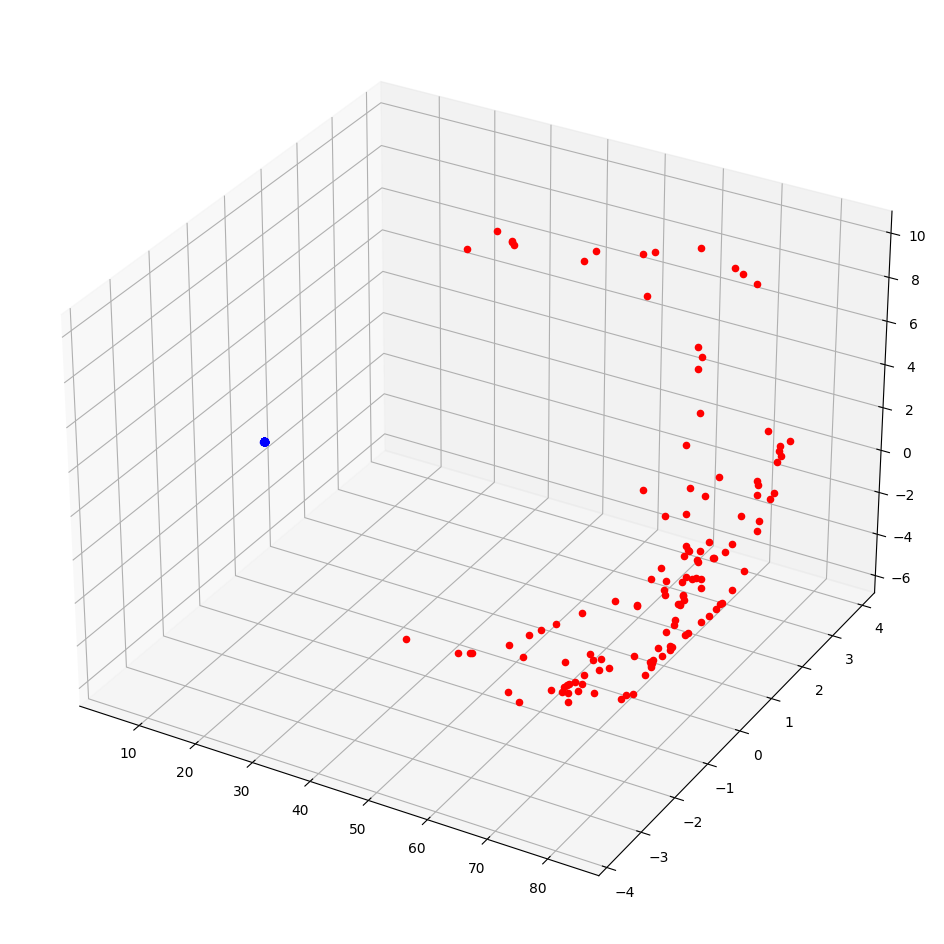

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming ga and other necessary modules are imported and initialized

origin = ga.e3
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

positional_error = []
rotational_error = []

translation = []
translation_pred = []

rotation = []
rotation_pred = []

# Assuming y_pred is a flattened list of predictions corresponding to the test dataset
y_pred_index = 0

for batch_index in range(len(test_dataset)):
    # Get a batch of test data
    _, y_test_batch = test_dataset[batch_index]
    position_batch = test_dataset.position[batch_index * test_dataset.batch_size:(batch_index + 1) * test_dataset.batch_size]

    for i in range(len(y_test_batch)):
        x = ga.geom_prod(ga.from_scalar(float(position_batch[i][0])), ga.e0) + ga.geom_prod(ga.from_scalar(float(position_batch[i][1])), ga.e1) + ga.geom_prod(ga.from_scalar(float(position_batch[i][2])), ga.e2)

        X = y_test_batch[i]
        Y = y_pred[y_pred_index][0]

        # Construct M and \hat{M}
        M_real = X[0] + ga.geom_prod(ga.from_scalar(float(X[1])), ga.e01) + ga.geom_prod(ga.from_scalar(float(X[2])), ga.e02) + ga.geom_prod(ga.from_scalar(float(X[3])), ga.e03) + ga.geom_prod(ga.from_scalar(float(X[4])), ga.e12) + ga.geom_prod(ga.from_scalar(float(X[5])), ga.e13) + ga.geom_prod(ga.from_scalar(float(X[6])), ga.e23) + ga.geom_prod(ga.from_scalar(float(X[7])), ga.e0123)
        M_pred = Y[0] + ga.geom_prod(ga.from_scalar(Y[1]), ga.e01) + ga.geom_prod(ga.from_scalar(Y[2]), ga.e02) + ga.geom_prod(ga.from_scalar(Y[3]), ga.e03) + ga.geom_prod(ga.from_scalar(Y[4]), ga.e12) + ga.geom_prod(ga.from_scalar(Y[5]), ga.e13) + ga.geom_prod(ga.from_scalar(Y[6]), ga.e23) + ga.geom_prod(ga.from_scalar(Y[7]), ga.e0123)

        # Normalizing
        M_pred = M_pred / mv_length(ga(M_pred))

        # Predicted and real displacement vector \hat{D}, D in spherical space
        S = ga.geom_prod(ga.geom_prod(M_pred, origin), ga.reversion(M_pred))
        T = ga.geom_prod(ga.geom_prod(M_real, origin), ga.reversion(M_real))

        # Predicted and real displacement vector \hat{d}, d in Euclidean space
        s = down1D(S, x)
        t = down1D(T, x)

        # POSITIONAL ERROR
        mae = np.mean(np.abs(np.array([t[1], t[2], t[3]]) - np.array([s[1], s[2], s[3]])))
        positional_error.append(mae)

        translation.extend([t[1], t[2], t[3]])
        translation_pred.extend([s[1], s[2], s[3]])

        # Plotting the camera trace
        ax.scatter(t[1], t[2], t[3], s=20, c="r")
        ax.scatter(s[1], s[2], s[3], s=20, c="b", alpha=0.5)

        Tup = translation_rotor(ga(ga.geom_prod(ga.from_scalar(t[1]), ga.e0)) + ga(ga.geom_prod(ga.from_scalar(t[2]), ga.e1)) + ga(ga.geom_prod(ga.from_scalar(t[3]), ga.e2)))
        Sup = translation_rotor(ga(ga.geom_prod(ga.from_scalar(s[1]), ga.e0) + ga.geom_prod(ga.from_scalar(s[2]), ga.e1) + ga.geom_prod(ga.from_scalar(s[3]), ga.e2)))

        # Predicted and real rotors \hat{R}, R
        R_pred = ga.geom_prod(ga.reversion(Sup.tensor), M_pred)
        R_real = ga.geom_prod(ga.reversion(Tup.tensor), M_real)

        # ROTATIONAL ERROR
        error = np.degrees(np.arccos(tf.clip_by_value((ga.geom_prod(R_real, ga.reversion(R_pred)))[0], -1.0, 1.0)))
        rotational_error.append(error)

        rotation.extend([R_real[0], R_real[6], R_real[7], R_real[10]])
        rotation_pred.extend([R_pred[0], R_pred[6], R_pred[7], R_pred[10]])

        y_pred_index += 1

plt.show()

# Storing rotational and translational errors
np.save("/content/drive/MyDrive/translation_error_7pkg_30_05_24.npy", positional_error)
np.save("/content/drive/MyDrive/rotational_error_7pkg_30_05_24.npy", rotational_error)

# Storing original and predicted translations
np.save("/content/drive/MyDrive/T_7pkg_30_05_24.npy", translation)
np.save("/content/drive/MyDrive/S_7pkg_30_05_24.npy", translation_pred)

# Storing original and predicted rotations
np.save("/content/drive/MyDrive/R_7pkg_30_05_24.npy", rotation)
np.save("/content/drive/MyDrive/Q_7pkg_30_05_24.npy", rotation_pred)


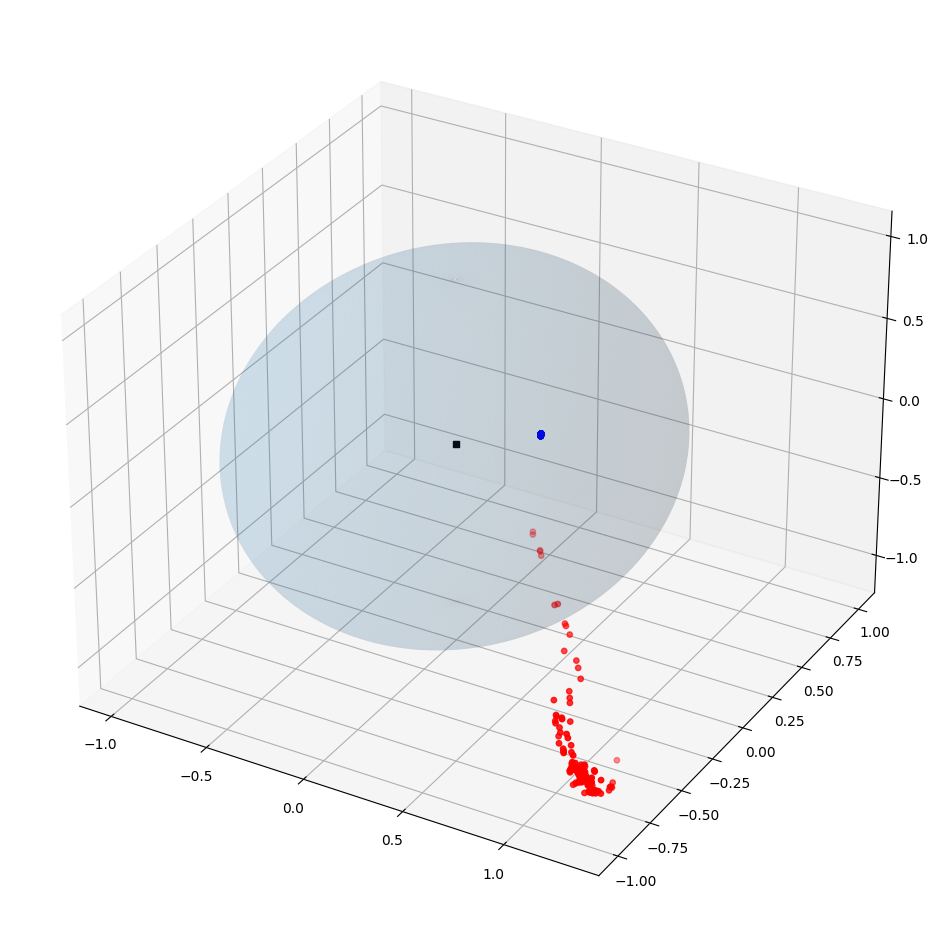

In [ ]:
#plotting the camera orientation (coefficients e_{01}, e_{02}, e_{12} of rotor R)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

N=200
stride=1

u = np.linspace(0, 2 * np.pi, N)
v = np.linspace(0, np.pi, N)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, linewidth=0.0, alpha = 0.1, cstride=stride, rstride=stride)

ax.scatter(0, 0, 0, c = "k", marker = "s", label = "O")

rotation = np.reshape(rotation, (-1, 4))
rotation_pred = np.reshape(rotation_pred, (-1, 4))
ax.scatter(rotation[:,1], rotation[:, 2], rotation[:,3], s = 15, c = "r")
ax.scatter(rotation_pred[:,1], rotation_pred[:, 2], rotation_pred[:,3], s = 15, c = "b")
plt.show()

In [ ]:
print(np.median(positional_error))
print(np.mean(positional_error))

0.5108402233339615
0.5553108006615315


In [ ]:
print(np.median(rotational_error))
print(np.mean(rotational_error))

22.01197985514972
28.128746439487646
